In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from params import *
import tqdm
import ghibtools as gh
import seaborn as sns
import pingouin as pg
%matplotlib inline

## TOOLS

APPROCHE PHASE

In [44]:
def load_resp(patient):
    rsp = pd.read_excel(f'../df_analyse/resp_features_{patient}.xlsx', index_col = 0)
    return rsp

In [45]:
def load_sp(patient):
    spindles = pd.read_excel(f'../df_analyse/spindles_{patient}.xlsx', index_col = 0)
    return spindles

In [46]:
def load_sw(patient):
    sw = pd.read_excel(f'../df_analyse/sw_{patient}.xlsx', index_col = 0)
    return sw

In [7]:
def count_events_phase_resp(nbins, patient, events, rsp_events, return_normal=True, save_rsp_encoded=False):
    
    rsp_cycles_with_event = []
    
    count = []

    for cycle in rsp_events.index: # loop only on cycles with spindles found inside
        
        start = rsp_events.loc[cycle,'inspi_time'] # get start time of the cycle
        stop = start + rsp_events.loc[cycle,'cycle_duration'] # get stop time of the cycle

        phases_timings = np.linspace(start, stop, nbins + 1) # slice the cycle time in n equal phase time points
        
        events_of_the_cycle = events[(events >= start) & (events <= stop)].values # keep the spindles of the cycle
        
        if events_of_the_cycle.shape[0] != 0:
            rsp_cycles_with_event.append(1)
        else:
            rsp_cycles_with_event.append(0)
        
        for event_time in events_of_the_cycle: # loop on spindles of the cycle
            for phase_bin, phase_start in enumerate(phases_timings): # loop on phases start times and attribute bin value to the phase
                if phase_start == phases_timings[-1]: # trick to stop looping if phase start == last phase timing
                    break 
                else:
                    phase_stop = phases_timings[phase_bin + 1] # stop time of this phase bin = next phase timing after the start phase timing of the list
                    if event_time >= phase_start and event_time < phase_stop: # if there is a spindle found between start and stop timings of the phase..
                        count.append(phase_bin) # ..the bin value is added to a counter

    if not return_normal: # return raw counts of spindles by bins
        phase_count = pd.Series(count).value_counts(normalize = False).reindex(np.arange(0,nbins))
        phase_count = phase_count.to_frame().T
    else: # return normalized counts of spindles by bins (each bin value = bin value / sum of all bin values) = default mode
        phase_count = pd.Series(count).value_counts(normalize = True).reindex(np.arange(0,nbins))
        phase_count = phase_count.to_frame().T
        mi = gh.Modulation_Index(phase_count.values)
        phase_count.insert(0 , 'mi', mi)

    phase_count.insert(0 , 'patient', patient)
    
    if save_rsp_encoded:
        if len(rsp_cycles_with_event) == rsp_events.shape[0]:
            rsp_events['event'] = rsp_cycles_with_event
            rsp_events.to_excel(f'../df_analyse/resp_features_encoded_{patient}.xlsx')
        else:
            assert ValueError('cycles encoded size different than rsp features size')
        
    return phase_count

In [8]:
def to_tidy(df):
    patients = df['patient'].values
    df = df.set_index('patient')
    rows = []
    for patient in patients:
        mi = df.loc[patient,'mi']
        phases = [col for col in df.columns if not col == 'mi']
        for phase in phases:
            phase_value = df.loc[patient,phase]
            rows.append([patient, mi , phase, phase_value])
    return pd.DataFrame(rows, columns = ['patient','mi','phase','bin value'])

## GO

In [9]:
save = False

concat_sp_phasing = []
concat_sw_phasing = []

nbins = 18

for patient in patients:
    print(patient)
    rsp = load_resp(patient)
    
    sp = load_sp(patient)
    concat_sp_phasing.append(count_events_phase_resp(nbins=nbins, patient=patient, events = sp['Peak'], rsp_events = rsp, save_rsp_encoded=save))
    
    sw = load_sw(patient)
    concat_sw_phasing.append(count_events_phase_resp(nbins=nbins, patient=patient, events = sw['Start'], rsp_events = rsp, save_rsp_encoded=False))
    
sp_phasing = pd.concat(concat_sp_phasing)
sw_phasing = pd.concat(concat_sw_phasing)

P1
P2
P3
P4
P5
P6
P7
P9
P10


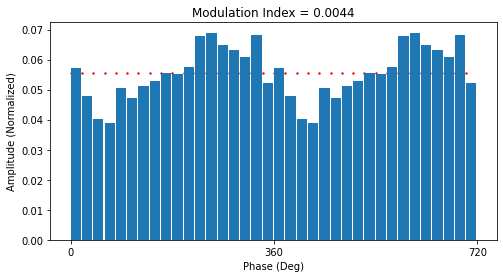

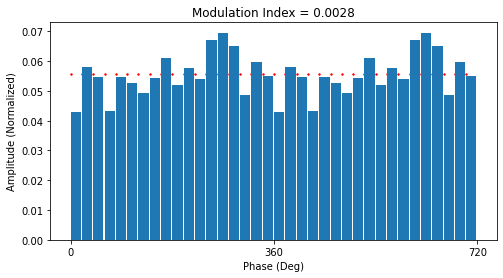

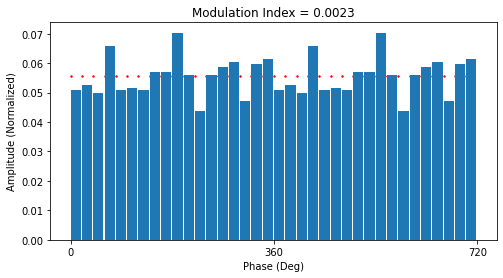

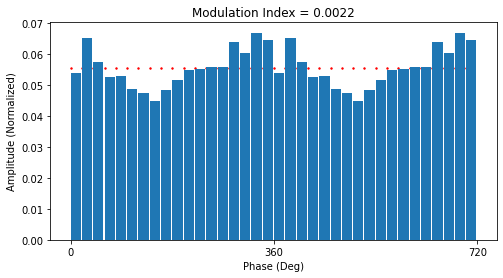

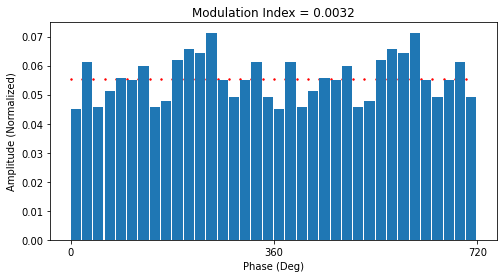

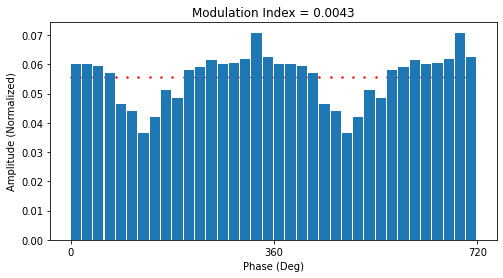

In [10]:
df = sp_phasing
for patient in patients:
    gh.Modulation_Index(df.set_index('patient').drop(columns = ['mi']).loc[patient,:].values, show = True)

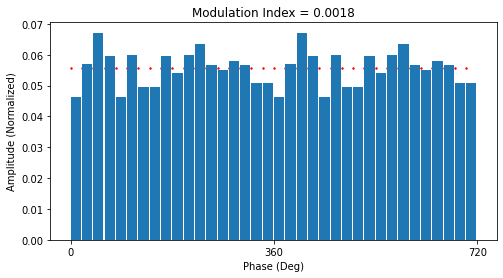

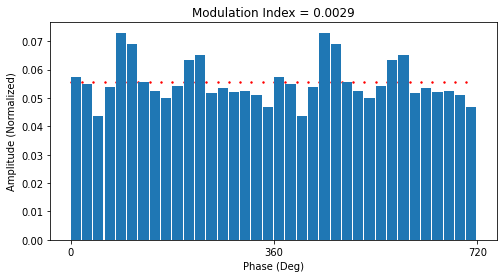

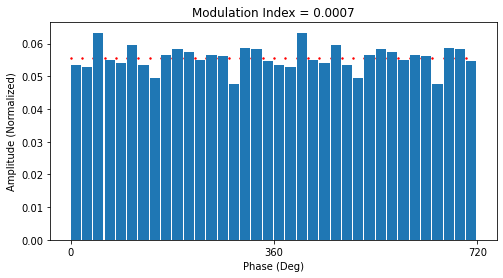

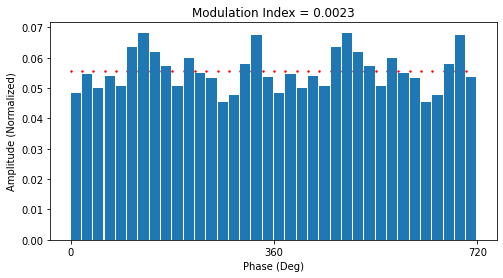

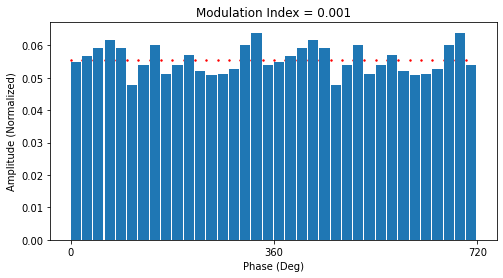

In [11]:
df = sw_phasing
for patient in patients:
    gh.Modulation_Index(df.set_index('patient').drop(columns = ['mi']).loc[patient,:].values, show = True)

/tmp/ipykernel_3392670/108609326.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  gh.Modulation_Index(sp_phasing.mean(), show = True)


0.016491243840595582

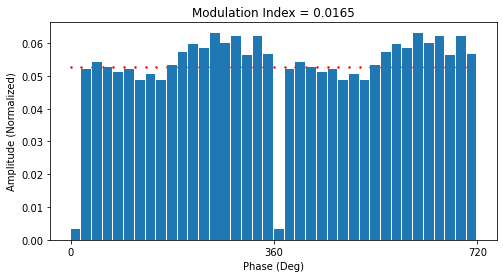

In [13]:
gh.Modulation_Index(sp_phasing.mean(), show = True)

In [14]:
gh.Modulation_Index(sw_phasing.mean(), show = True)

/tmp/ipykernel_3392670/1583766394.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  gh.Modulation_Index(sw_phasing.mean(), show = True)


0.01629669118726674

In [15]:
sw_phasing['mi'].mean()

0.0022553142190366348

In [16]:
save = False

concat_sp_phasing = []
concat_sw_phasing = []

nbins = 2

for patient in patients:
    print(patient)
    rsp = load_resp(patient)
    
    sp = load_sp(patient)
    concat_sp_phasing.append(count_events_phase_resp(nbins=nbins, patient=patient, events = sp['Peak'], rsp_events = rsp, save_rsp_encoded=save))
    
    sw = load_sw(patient)
    concat_sw_phasing.append(count_events_phase_resp(nbins=nbins, patient=patient, events = sw['Start'], rsp_events = rsp, save_rsp_encoded=False))
    
sp_phasing = pd.concat(concat_sp_phasing)
sw_phasing = pd.concat(concat_sw_phasing)

P1
P2
P3
P4
P5
P6
P7
P9
P10


In [17]:
sp_phasing_tidy = to_tidy(sp_phasing)

In [18]:
sp_phasing_tidy

patient        mi  phase  bin value
0       P1  0.003998      0   0.462794
1       P1  0.003998      1   0.537206
2       P2  0.009257      0   0.443420
3       P2  0.009257      1   0.556580
4       P3  0.010016      0   0.441152
5       P3  0.010016      1   0.558848
6       P4  0.002295      0   0.471807
7       P4  0.002295      1   0.528193
8       P5  0.002420      0   0.471050
9       P5  0.002420      1   0.528950
10      P6  0.000550      0   0.486198
11      P6  0.000550      1   0.513802
12      P7  0.002346      0   0.471494
13      P7  0.002346      1   0.528506
14      P9  0.003108      0   0.467190
15      P9  0.003108      1   0.532810
16     P10  0.005312      0   0.457120
17     P10  0.005312      1   0.542880

In [19]:
ttest = pg.ttest(x= sp_phasing_tidy[sp_phasing_tidy['phase']==1]['bin value'] , y=0.5)

In [20]:
ttest

T  dof alternative     p-val         CI95%   cohen-d     BF10  \
T-test  7.5791    8   two-sided  0.000064  [0.53, 0.55]  2.526367  408.625   

           power  
T-test  0.999997

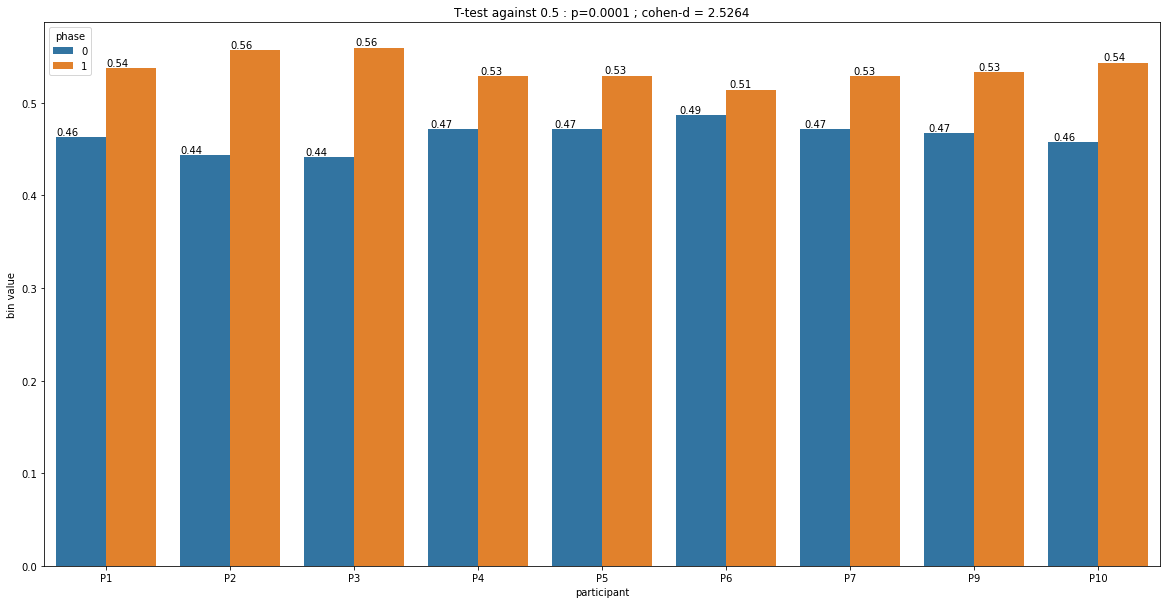

In [24]:
fig, ax = plt.subplots(figsize = (20,10))
sns.barplot(data =sp_phasing_tidy, x='patient', y ='bin value', hue = 'phase', ax=ax)
ax.set_xlabel('participant')
p = ttest.loc['T-test', 'p-val'].round(4)
cohen = ttest.loc['T-test', 'cohen-d'].round(4)
ax.set_title(f'T-test against 0.5 : p={p} ; cohen-d = {cohen}')
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1.005, p.get_height() * 1.005))
# plt.savefig('../presentation_2/bar_2_bins')

APPROCHE TIME

In [25]:
def get_timestamps(df_cycles, spindles_times, patient):
    rows = []

    for cycle in df_cycles.index: # loop only on cycles with spindles found inside

        start = df_cycles.loc[cycle,'inspi_time'] # get start time of the cycle
        transition = df_cycles.loc[cycle,'expi_time'] # get i-e time of the cycle
        stop = start + df_cycles.loc[cycle,'cycle_duration'] # get stop time of the cycle
        duration = df_cycles.loc[cycle,'cycle_duration']
        inspi_duration = transition - start
        expi_duration = stop - transition

        spindles_of_the_cycle = spindles_times[(spindles_times >= start) & (spindles_times <= stop)].values # keep the spindles of the cycle

        for spindle_time in spindles_of_the_cycle: # loop on spindles of the cycle
            time_post_start = spindle_time - start
            time_vs_transition = spindle_time - transition
            time_pre_end = stop - spindle_time

            norm_time = (spindle_time - start) / duration

            rows.append([patient, cycle, start, transition, stop, inspi_duration, expi_duration, duration, spindle_time, time_post_start, time_vs_transition, time_pre_end, norm_time])
    df_times = pd.DataFrame(rows, columns = ['patient','cycle','start cycle', 'transition ie', 'stop cycle', 'inspi duration','expi duration','cycle duration','spindle time', 'time post start', 'time vs transition ie','time pre end','norm time'])
    return df_times

In [26]:
concat_df_times = []

for patient in patients:
    df_cycles, spindles_times = load_resp(patient), load_sp(patient)['Peak']
    concat_df_times.append(get_timestamps(df_cycles, spindles_times, patient))
    
df_times_all = pd.concat(concat_df_times)

In [27]:
df_cycles

participant  cycle_num  inspi_index  expi_index    inspi_time  \
0            P10          0          785        1093      3.066406   
1            P10          1         1621        1927      6.332031   
2            P10          2         2515        2818      9.824219   
3            P10          3         3328        3655     13.000000   
4            P10          4         4295        4604     16.777344   
...          ...        ...          ...         ...           ...   
3302         P10       3302      3351173     3351466  13090.519531   
3303         P10       3303      3351992     3352298  13093.718750   
3304         P10       3304      3352852     3353141  13097.078125   
3305         P10       3305      3353678     3353963  13100.304688   
3306         P10       3306      3354498     3354803  13103.507812   

         expi_time  cycle_duration  insp_duration  exp_duration  cycle_freq  \
0         4.269531        3.265625       1.203125      2.062500    0.306220   
1         7.527344        3.492188       1.195312      2.296875    0.286353   
2        11.007812        3.175781       1.183594      1.992188    0.314883   
3        14.277344        3.777344       1.277344      2.500000    0.264736   
4        17.984375        3.277344       1.207031      2.070312    0.305125   
...            ...             ...            ...           ...         ...   
3302  13091.664062        3.199219       1.144531      2.054688    0.312576   
3303  13094.914062        3.359375       1.195312      2.164062    0.297674   
3304  13098.207031        3.226562       1.128906      2.097656    0.309927   
3305  13101.417969        3.203125       1.113281      2.089844    0.312195   
3306  13104.699219        3.144531       1.191406      1.953125    0.318012   

      insp_volume  exp_volume  total_amplitude  insp_amplitude  exp_amplitude  
0       75.456871   33.300273       105.509405       74.332829      31.176576  
1       76.591844   42.412419       109.985937       78.890869      31.095068  
2       70.728797   36.833782       102.973581       71.720908      31.252673  
3       64.021664   54.442185        89.835185       58.642074      31.193111  
4       62.312316   43.214275        94.471200       63.223691      31.247509  
...           ...         ...              ...             ...            ...  
3302    75.023351   21.572221       119.843260       88.822067      31.021193  
3303    80.619820   24.688152       119.738339       88.812426      30.925913  
3304    80.977879   22.006793       125.001182       93.702418      31.298763  
3305    78.205671   30.865115       125.757858       94.618876      31.138982  
3306    78.976364    5.633236       119.464780       85.194323      34.270457  

[3300 rows x 15 columns]

In [28]:
spindles_times

0          34.722656
1          53.281250
2          63.980469
3          81.832031
4         148.375000
            ...     
3572    14133.718750
3573    14598.128906
3574    14614.339844
3575    14791.289062
3576    14932.996094
Name: Peak, Length: 3577, dtype: float64

In [29]:
df_times_all

patient  cycle   start cycle  transition ie    stop cycle  \
0         P1     15     45.316406      46.406250     47.960938   
1         P1     15     45.316406      46.406250     47.960938   
2         P1     19     57.113281      58.273438     60.230469   
3         P1     20     60.230469      61.289062     63.234375   
4         P1     20     60.230469      61.289062     63.234375   
...      ...    ...           ...            ...           ...   
2538     P10   3173  12673.343750   12674.546875  12676.808594   
2539     P10   3186  12716.195312   12717.453125  12719.339844   
2540     P10   3193  12739.273438   12740.433594  12742.562500   
2541     P10   3259  12952.140625   12953.324219  12955.007812   
2542     P10   3287  13041.324219   13042.535156  13044.519531   

      inspi duration  expi duration  cycle duration  spindle time  \
0           1.089844       1.554688        2.644531     46.878906   
1           1.089844       1.554688        2.644531     46.507812   
2           1.160156       1.957031        3.117188     59.421875   
3           1.058594       1.945312        3.003906     62.152344   
4           1.058594       1.945312        3.003906     62.066406   
...              ...            ...             ...           ...   
2538        1.203125       2.261719        3.464844  12674.621094   
2539        1.257812       1.886719        3.144531  12718.800781   
2540        1.160156       2.128906        3.289062  12741.890625   
2541        1.183594       1.683594        2.867188  12953.480469   
2542        1.210938       1.984375        3.195312  13041.519531   

      time post start  time vs transition ie  time pre end  norm time  
0            1.562500               0.472656      1.082031   0.590842  
1            1.191406               0.101562      1.453125   0.450517  
2            2.308594               1.148438      0.808594   0.740602  
3            1.921875               0.863281      1.082031   0.639792  
4            1.835938               0.777344      1.167969   0.611183  
...               ...                    ...           ...        ...  
2538         1.277344               0.074219      2.187500   0.368658  
2539         2.605469               1.347656      0.539062   0.828571  
2540         2.617188               1.457031      0.671875   0.795724  
2541         1.339844               0.156250      1.527344   0.467302  
2542         0.195312              -1.015625      3.000000   0.061125  

[29147 rows x 13 columns]

In [30]:
fig, axs = plt.subplots(nrows = 2, ncols = 5, subplot_kw=dict(projection = 'polar'), figsize = (30,15), constrained_layout = True)
fig.suptitle('Polar plot of normalized count of spindles by phase bin', fontsize = 30)
bins = 18
for row, sublist in enumerate([ patients[:5], patients[5:]]):
    for col, patient in enumerate(sublist):
        ax = axs[row, col]
        hist , values = np.histogram(df_times_all[df_times_all['patient'] == patient]['norm time'], bins = bins, density = True)
        ax.bar(np.linspace(0,2*np.pi,bins), hist / sum(hist))
        ax.set_rticks([1/bins])
        ax.set_title(f'{patient}', fontsize = 15, y = 1.05)
# plt.savefig('../presentation_4/detailed_polar_plot')

In [32]:
fig, ax = plt.subplots(subplot_kw=dict(projection = 'polar'), figsize = (10,10))
fig.suptitle('Mean polar plot of normalized count of spindles by phase bin', fontsize = 15)
bins = 18
hist , values = np.histogram(df_times_all['norm time'], bins = bins, density = False)
ax.bar(np.linspace(0,2*np.pi,bins), hist / sum(hist))
# ax.set_rmax(0.08)
ax.set_rticks([1/bins])
# plt.savefig('../presentation_4/mean_polar_plot')

<AxesSubplot:ylabel='Frequency'>

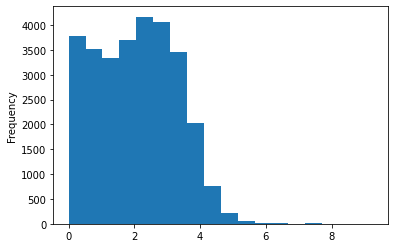

In [33]:
df_times_all['time post start'].plot.hist(bins = 18)

<AxesSubplot:ylabel='Frequency'>

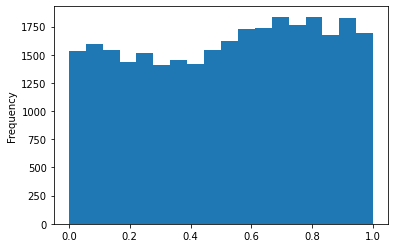

In [34]:
df_times_all['norm time'].plot.hist(bins=18)

In [35]:
df_times_all['spindle time'].plot.hist(bins = 100)

<AxesSubplot:ylabel='Frequency'>

In [36]:
df_times_all['time post start'].plot.hist(bins = 100)

<AxesSubplot:ylabel='Frequency'>

<AxesSubplot:ylabel='Frequency'>

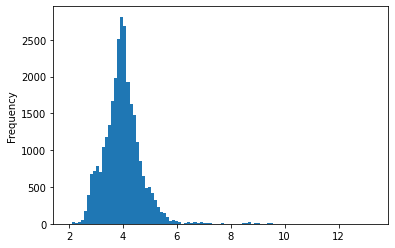

In [37]:
df_times_all['cycle duration'].plot.hist(bins = 100)

<AxesSubplot:ylabel='Frequency'>

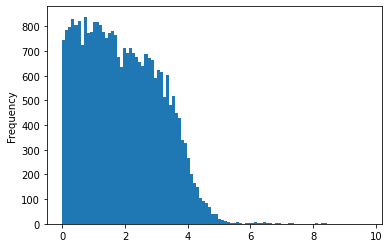

In [38]:
df_times_all['time pre end'].plot.hist(bins = 100)

In [39]:
def get_event_plot_patient(df, patient, ax=None, colname = 'norm time'):
    df_patient =  df[(df['patient'] == patient)][['cycle',colname,'cycle duration']].sort_values(by = 'cycle duration')
    rows = []
    for c in df_patient['cycle'].unique():
        row = df_patient[df_patient['cycle'] == c]
        rows.append(list(row[colname].values) )
        
    if ax is None:
        fig, ax = plt.subplots()
    ax.eventplot(rows,linelengths=10, linewidth = 2, colors = 'black')
    return ax

In [40]:
fig, axs = plt.subplots(ncols = 2, nrows = 5, figsize = (10,10), constrained_layout = True)
fig.suptitle('Raster plot of normalized timings of spindles during respiration cycle', fontsize = 15)
for col, semi_list in enumerate([patients[:5],patients[5:]]):
    for row, patient in enumerate(semi_list):
        ax = axs[row, col]
        ax = get_event_plot_patient(df=df_times_all, patient=patient, ax=ax, colname = 'norm time')
        ax.set_title(patient)
        ax.set_ylabel('respiration cycle')
        ax.set_xlabel('Respiration Phase')
# plt.savefig('../presentation_4/raster_plot_normalized')
plt.show()

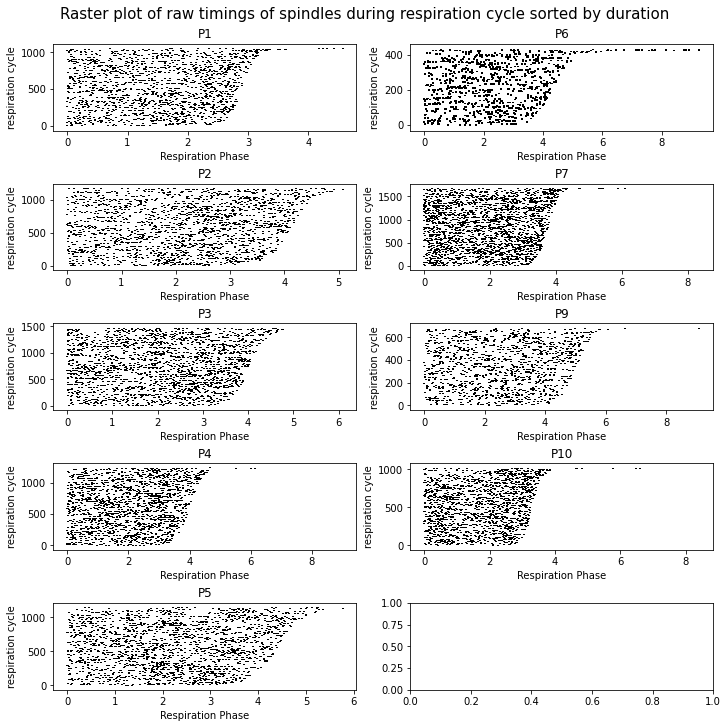

In [41]:
fig, axs = plt.subplots(ncols = 2, nrows = 5, figsize = (10,10), constrained_layout = True)
fig.suptitle('Raster plot of raw timings of spindles during respiration cycle sorted by duration', fontsize = 15)
for col, semi_list in enumerate([patients[:5],patients[5:]]):
    for row, patient in enumerate(semi_list):
        ax = axs[row, col]
        ax = get_event_plot_patient(df=df_times_all, patient=patient, ax=ax, colname = 'time post start')
        ax.set_title(patient)
        ax.set_ylabel('respiration cycle')
        ax.set_xlabel('Respiration Phase')
# plt.savefig('../presentation_4/raster_plot_sorted')
plt.show()